In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.core.display import display, HTML
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('../spectrograms_tugs.pkl', 'rb') as specgram_file:
    patients = pickle.load(specgram_file)

specgrams = [patient['specgram'] for patient in patients]
print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 72


In [4]:
# Split dataset between train and test
train, X_test = train_test_split(specgrams, test_size=0.25, shuffle=False)
print('Training samples: ' + str(len(train)))
print('Test samples: ' + str(len(X_test)))

Training samples: 54
Test samples: 18


In [5]:
# Flip
X_train = []
for specgram in train:
    X_train.append(specgram)
    X_train.append(np.flip(specgram, 0))  # flip rows / y axis
    X_train.append(np.flip(specgram, 1))  # flip columns / x axis
    X_train.append(np.flip(specgram, (0, 1)))  # flip rows and columns / x and y axis

print(len(X_train))

216


In [6]:
# Obtain 3 dimensional shape
dim = X_train[0].shape
if len(dim) < 3:
    dim += (1,)
print(dim)

(20, 200, 1)


In [7]:
# Add gaussian noise
noise_factor = 0.05

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

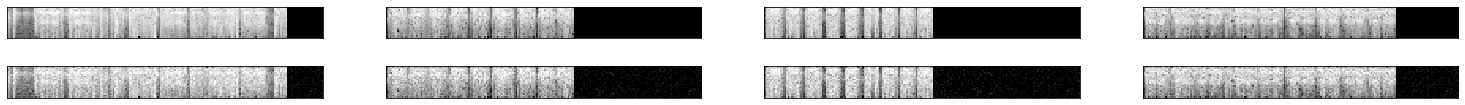

In [8]:
# Visualize original x noisy
n=4
plt.figure(figsize=(26, 2))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    ax.imshow(X_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i+n+1)
    ax.imshow(X_test_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [9]:
# Reshape images to be 3 dimensional
X_train = np.reshape(X_train, (len(X_train), dim[0], dim[1], dim[2]))
X_test = np.reshape(X_test, (len(X_test), dim[0], dim[1], dim[2]))

X_train_noisy = np.reshape(X_train_noisy, (len(X_train_noisy), dim[0], dim[1], dim[2]))
X_test_noisy = np.reshape(X_test_noisy, (len(X_test_noisy), dim[0], dim[1], dim[2]))

## Autoencoder Model

In [10]:
input_img = Input(shape=dim)

# encoder
code = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(4, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(1, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = MaxPooling2D(pool_size=(5, 5))(code)
# code = Conv2D(2, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = Flatten()(code)
bottleneck = Dense(128, activation='relu')(code)  # bottleneck

# decoder
x_hat = Dense(250, activation='relu')(bottleneck)
x_hat = Reshape((5, 50, 1))(x_hat)
x_hat = Conv2DTranspose(4, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(16, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 200, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 200, 16)       416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 200, 16)       64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 100, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 100, 4)        1604      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 100, 4)        16        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 50, 4)          0         
__________

In [11]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=50),
             ModelCheckpoint(filepath='best_model_TUGs_128.h5', monitor='val_loss', save_best_only=True)]

In [12]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
# autoencoder.compile(loss='mse', optimizer='adam')

# tamanho do batch por iteracao
batch_size = 25

# número de épocas 
epochs = 1000

# a variável history guarda os dados do processo de treinamento para posteriormente analisarmos
history = autoencoder.fit([X_train_noisy], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks, # Early stopping
                    verbose=1,
                    validation_data=([X_test_noisy], [X_test]))

Train on 216 samples, validate on 18 samples
Epoch 1/1000
216/216 [==============================] - 2s 9ms/step - loss: 0.1301 - val_loss: 0.1088
Epoch 2/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0587 - val_loss: 0.0690
Epoch 3/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0416 - val_loss: 0.0593
Epoch 4/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0356 - val_loss: 0.0500
Epoch 5/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0325 - val_loss: 0.0471
Epoch 6/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0302 - val_loss: 0.0361
Epoch 7/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0282 - val_loss: 0.0344
Epoch 8/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0271 - val_loss: 0.0355
Epoch 9/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0265 - val_loss: 0.0311
Epoch 10/1000
216/216 [==============

216/216 [==============================] - 1s 6ms/step - loss: 0.0132 - val_loss: 0.0134
Epoch 81/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0134 - val_loss: 0.0130
Epoch 82/1000
216/216 [==============================] - 1s 5ms/step - loss: 0.0130 - val_loss: 0.0121
Epoch 83/1000
216/216 [==============================] - 1s 5ms/step - loss: 0.0136 - val_loss: 0.0130
Epoch 84/1000
216/216 [==============================] - 1s 5ms/step - loss: 0.0129 - val_loss: 0.0127
Epoch 85/1000
216/216 [==============================] - 1s 5ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 86/1000
216/216 [==============================] - 1s 5ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 87/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0129 - val_loss: 0.0131
Epoch 88/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 89/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0131 - v

216/216 [==============================] - 1s 6ms/step - loss: 0.0125 - val_loss: 0.0107
Epoch 160/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 161/1000
216/216 [==============================] - 1s 7ms/step - loss: 0.0121 - val_loss: 0.0132
Epoch 162/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0119 - val_loss: 0.0111
Epoch 163/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0120 - val_loss: 0.0115
Epoch 164/1000
216/216 [==============================] - 1s 5ms/step - loss: 0.0122 - val_loss: 0.0118
Epoch 165/1000
216/216 [==============================] - 1s 5ms/step - loss: 0.0119 - val_loss: 0.0124
Epoch 166/1000
216/216 [==============================] - 1s 5ms/step - loss: 0.0127 - val_loss: 0.0115
Epoch 167/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 168/1000
216/216 [==============================] - 1s 5ms/step - loss: 0

Epoch 238/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 239/1000
216/216 [==============================] - 1s 5ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 240/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 241/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 242/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0116
Epoch 243/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 244/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 245/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0123 - val_loss: 0.0105
Epoch 246/1000
216/216 [==============================] - 1s 6ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 247/1000
216/216 [==============================] - 1s 6ms

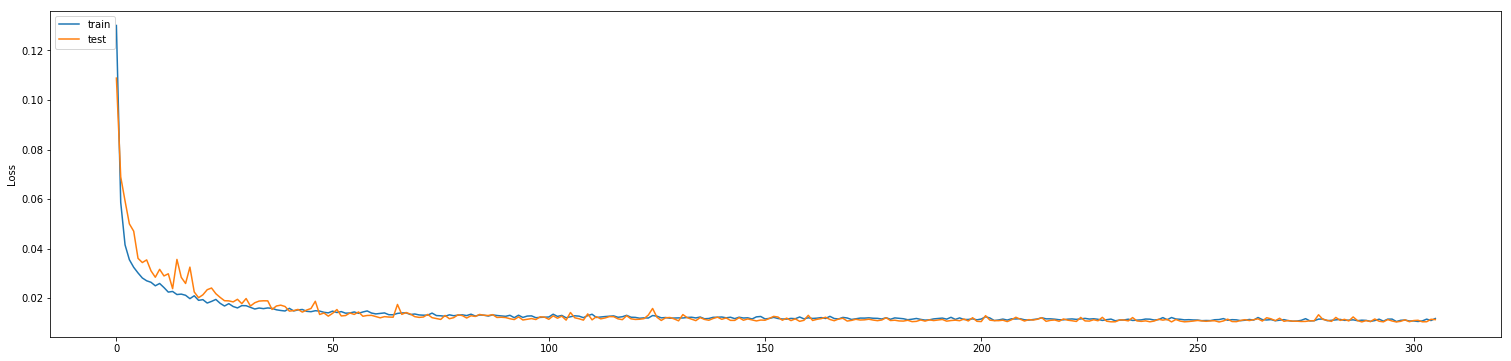

In [13]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
# load best model
autoencoder = load_model('best_model_TUGs_128.h5')

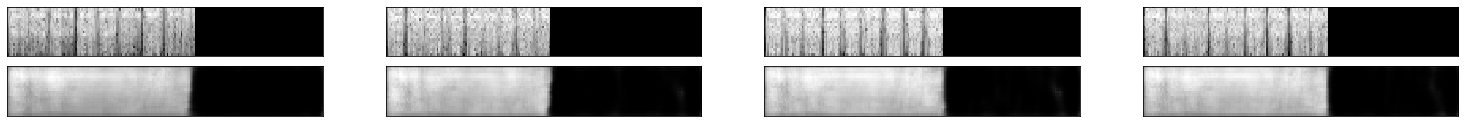

In [15]:
decoded_test = np.reshape(X_test, (len(X_test), dim[0], dim[1]))
decoded_predictions = autoencoder.predict([X_test])
decoded_predictions = np.reshape(decoded_predictions, (len(decoded_predictions), dim[0], dim[1]))

plt.figure(figsize=(26, 2))
start, stop = 10, 14
for i, n in enumerate(range(start, stop), start=1):
    ax = plt.subplot(2, stop-start, i)
    plt.imshow(decoded_test[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, stop-start, i+stop-start)
    plt.imshow(decoded_predictions[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()